# CS 666 Project
[![]( https://img.shields.io/badge/Python-v3.7-orange)]()
[![](https://img.shields.io/badge/keras-v1.2-blue)]()
[![](https://img.shields.io/badge/sklearn-v0.23-yellowgreen)]()

#### Members : [Leyu,Lin]  [Parth Thummar]

##### We were requesting serach log data from yahoo serach enginee, but the requests get pending for three weeks.
##### Then we decide use home depot dataset as second choice due to time limit. 

#### Import library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm  
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import brown, stopwords
from bs4 import BeautifulSoup
from string import punctuation
from nltk.cluster.util import cosine_distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from matplotlib import pyplot

#### DataSet path

In [22]:
st = SnowballStemmer('english') 
df_train = pd.read_csv('./train/train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('./test/test.csv', encoding="ISO-8859-1")
df_attr = pd.read_csv('./attributes/attributes.csv')
df_product_detail = pd.read_csv('./product_descriptions/product_descriptions.csv')

#### DataSet Exploring

##### the relevance is computed with entorpy fomular PlogP 
##### The probalities is P(product | six attributes)
##### the relevance value is for evaluted embedding fuzzy features (macth the user seraches with actual product description)

In [3]:
df_train.head(10)

,id,product_uid,product_title,search_term,State,evaluted_score,entropy
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,AL,1.764706,2.73
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,AL,1.470588,2.27
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,AL,1.764706,2.73
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,AL,1.370588,2.12
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,AL,1.570588,2.43
5,18,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,AL,1.764706,2.73
6,20,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwave over stove,AL,1.570588,2.43
7,21,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,AL,1.764706,2.73
8,23,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,emergency light,AL,1.570588,2.43
9,27,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,AL,1.764706,2.73


In [4]:
df_test.head(10)

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668
5,8,100001,Simpson Strong-Tie 12-Gauge Angle,wood connectors
6,10,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath and shower kit
7,11,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,bath drain kit
8,12,100003,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,one piece tub shower
9,13,100004,Grape Solar 265-Watt Polycrystalline Solar Pan...,solar panel


In [5]:
df_attr.head(10)

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel
5,100001.0,Bullet06,Galvanized for extra corrosion resistance
6,100001.0,Bullet07,Install with 10d common nails or #9 x 1-1/2 in...
7,100001.0,Gauge,12
8,100001.0,Material,Galvanized Steel
9,100001.0,MFG Brand Name,Simpson Strong-Tie


In [6]:
df_product_detail.head(10)

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...
5,100006,Achieving delicious results is almost effortle...
6,100007,The Quantum Adjustable 2-Light LED Black Emerg...
7,100008,The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8,100009,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9,100010,Valley View Industries Metal Stakes (4-Pack) a...


In [7]:
df_train.describe()

,id,product_uid,evaluted_score,entropy
count,74067.000000,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,1.400961,2.167297
std,64016.573650,30770.774864,0.314108,0.485952
min,2.000000,100001.000000,0.588235,0.910000
25%,57163.500000,115128.500000,1.176471,1.820000
50%,113228.000000,137334.000000,1.370588,2.120000
75%,168275.500000,166883.500000,1.764706,2.730000
max,221473.000000,206650.000000,1.764706,2.730000


In [8]:
df_train.describe()

,id,product_uid,evaluted_score,entropy
count,74067.000000,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,1.400961,2.167297
std,64016.573650,30770.774864,0.314108,0.485952
min,2.000000,100001.000000,0.588235,0.910000
25%,57163.500000,115128.500000,1.176471,1.820000
50%,113228.000000,137334.000000,1.370588,2.120000
75%,168275.500000,166883.500000,1.764706,2.730000
max,221473.000000,206650.000000,1.764706,2.730000


In [9]:
np.shape(df_train)

(74067, 7)

##### Theare are 240k queries 

#### Data preprocesse

##### the first thing will be swap words such as seraching , serached, seraches to serach use stemmer
##### this step important for matching and computing relevance column

In [10]:
def str_stripper(s):
    return " ".join([st.stem(word) for word in s.lower().split()])

def to_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())

#combine data set in one dataframe
df_train_test = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_comb = pd.merge(df_train_test, df_product_detail, how='left', on='product_uid')
df_comb

,id,product_uid,product_title,search_term,State,evaluted_score,entropy,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,AL,1.764706,2.73,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,AL,1.470588,2.27,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,AL,1.764706,2.73,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,AL,1.370588,2.12,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,AL,1.570588,2.43,Update your bathroom with the Delta Vero Singl...
...,...,...,...,...,...,...,...,...
240755,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet,NaN,NaN,NaN,Create a neat yet stylish storage space for or...
240756,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion,NaN,NaN,NaN,Our Bullnose Adirondack Chair Cushions fit Adi...
240757,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb,NaN,NaN,NaN,Joist hangers are designed to provide support ...
240758,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets,NaN,NaN,NaN,These socket cap screws are ideal for applicat...


##### Notice NaN appear on column because some value is missing in dataset
##### when computer compute evaluated score will become NaN

In [ ]:
df_comb['search_term'] = df_comb['search_term'].map(lambda x:str_stripper(x))
df_comb['product_title'] = df_comb['product_title'].map(lambda x:str_stripper(x))
df_comb['product_description'] = df_comb['product_description'].map(lambda x:str_stripper(x))
df_comb['len_of_query'] = df_comb['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_comb['product_info'] = df_comb['search_term']+"\t"+df_comb['product_title']+"\t"+df_comb['product_description']
df_comb['word_in_title'] = df_comb['product_info'].map(lambda x:to_common_word(x.split('\t')[0],x.split('\t')[1]))
df_comb['word_in_description'] = df_comb['product_info'].map(lambda x:to_common_word(x.split('\t')[0],x.split('\t')[2]))
df_comb.head(10)

#### Since 204k queries is a lot, we narrow set to be 76k for train,test

In [11]:
# 76k queries for train and test set
max_size = df_train.shape[0]
df_train = df_comb.iloc[:max_size]
df_test = df_comb.iloc[max_size:]
id_test = df_test['id']
y_train = df_train['evaluted_score '].values
X_train = df_train[[w for w in list(df_train.columns) if w not in ['search_term',
                                                                   'product_title',
                                                                   'product_description',
                                                                   'product_info' , 
                                                                   'id',
                                                                   'entropy']]].values
X_test = df_test[[w for w in list(df_test.columns) if w not in ['search_term',
                                                                'product_title',
                                                                'product_description',
                                                                'product_info' ,
                                                                'id',
                                                                'entropy']]].values

#### plot train vs entropy

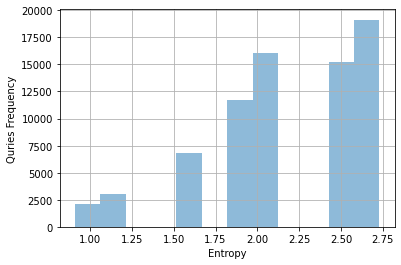

In [12]:
df_train.entropy.hist(bins=12, alpha=0.5)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.ylabel('Quries Frequency')
plt.xlabel('Entropy')
plt.show()

In [13]:
df_test.corr()

,id,product_uid,evaluted_score,entropy
id,1.00000,0.98424,NaN,NaN
product_uid,0.98424,1.00000,NaN,NaN
evaluted_score,NaN,NaN,NaN,NaN
entropy,NaN,NaN,NaN,NaN


##### Encounter problems, reconstruct frames
##### try new apporach with smilarilty and extract work token first, then write custimized stemmer

In [14]:
def sentence_similarity(columns,end=None):
    s1, s2 = columns[0], columns[1]
    s1 = s1.split(' ')
    s2 = s2.split(' ')
    if end is None:
        end = []
 
    s1 = [word.lower() for word in s1]
    s2 = [word.lower() for word in s2]
    words = list(set(s1 + s2))
 
    v1 = [0] * len(words)
    v2 = [0] * len(words)
 
    for word in s1:
        if word in end:
            continue
        v1[words.index(word)] += 1
 
    for word in s2:
        if word in end:
            continue
        v2[words.index(word)] += 1
 
    return 1 - cosine_distance(v1, v2)

def get_similarity(columns): 
    str1, str2 = columns[0], columns[1]
    se1 = set(str1)
    se2 = set(str2)
    se3 = se1.intersection(se2)
    return float(len(se3)) / (len(se1) + len(se2) - len(se3))


def calc_score(row):
    return edit_distance(*row)

##### use python soup package

In [15]:
# new remove html tag form url
# I notice sentence result NaN in dataSet 
def remove_html(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

# parsing agin with manul version stemmer
def cus_stemmer(doc):
    tok = doc.split()
    table = str.maketrans('', '', punctuation)
    tok = [word.translate(table) for word in tok]
    tok = [word for word in tok if word.isalpha()]
    end = set(stopwords.words('english'))
    tok = [word for word in tok if not word in end]
    tok = [word for word in tok if len(word) > 1]
    return ' '.join(tok)


def str_tok(tok):
    table = str.maketrans('', '', punctuation)
    tok = [word.translate(table) for word in tok]
    # check if is not alpha letter
    tok = [word for word in tok if word.isalpha()]
    end = set(stopwords.words('english'))
    tok = [word for word in tok if not word in end]
    tok = [word for word in tok if len(word) > 1]
    return ' '.join(tok)

def str_title(s):
    return " ".join(map(st.stem, s))

def str_word(str1, str2):
    whole_set = set(str1.split())
    return sum(int(str2.find(word)>=0) for word in whole_set)

def str_wrod2(str1, str2):
    part_of_first = set(str1)
    return sum(1 for word in str2 if word in part_of_first)

def get_matched_word(row_data):
    return np.sum([str_wrod2(*row_data[:-1]), str_wrod2(*row_data[1:])])

def get_unmatched_word(row_data):
    return np.sum([str_wrod2(*row_data[:-1]), str_wrod2(*row_data[1:])])


In [16]:
# reformat everthing in original frames
df_newComb = df_train.copy()
df_newComb['search_token'] = df_newComb.search_term.str.lower().str.split()
df_newComb['title_token'] = df_newComb.product_title.str.lower().str.split()
df_newComb['product_description_token'] = df_newComb.product_description.str.lower().str.split()
df_newComb['search_term'] = [str_title(_) for _ in df_newComb.search_token.values.tolist()]
df_newComb['product_title'] = [str_tok(_) for _ in df_newComb.title_token.values.tolist()]
df_newComb['product_description'] = [str_tok(_) for _ in df_newComb.product_description_token.values.tolist()]
df_newComb['matched_wrods'] = [get_matched_word(columns) for columns in df_newComb[['search_token', 'title_token', 'product_description_token']].values.tolist()]
df_newComb['unmateched_wrods'] = list(map(get_unmatched_word, df_train[['search_term','product_description', 'product_title']].values))
df_newComb['similarity_search_title'] = [get_similarity(rows) for rows in df_newComb[["search_token","title_token"]].values]
df_newComb['similarity_search_product'] = [get_similarity(rows) for rows in df_newComb[["search_token","product_description_token"]].values]
df_newComb['search_query_length'] = df_train.search_term.str.len()
df_newComb['words_in_product'] = df_train.product_description.str.count("\\w+")
df_newComb['fit_curve'] = [sentence_similarity(rows) for rows in df_newComb[["search_term","product_description"]].values]
df_newComb['similarity_search_title_sentence'] = [ sentence_similarity(rows) for rows in df_newComb[["search_term","product_title"]].values]
df_newComb['similarity_search_product_sentence'] = [sentence_similarity(rows) for rows in df_newComb[["search_term","product_description"]].values]

In [20]:
df_newComb.head(5)


,id,product_uid,product_title,search_term,State,evaluted_score,entropy,product_description,search_token,title_token,product_description_token,matched_wrods,unmateched_wrods,similarity_search_title,similarity_search_product,search_query_length,words_in_product,fit_curve,similarity_search_title_sentence,similarity_search_product_sentence
0,2,100001,simpson strongtie angle,angl bracket,AL,1.764706,2.73,angles make joints stronger also provide consi...,"[angle, bracket]","[simpson, strong-tie, 12-gauge, angle]","[not, only, do, angles, make, joints, stronger...",4,527,0.200000,0.000000,13,140,0.000000,0.00000,0.000000
1,3,100001,simpson strongtie angle,l bracket,AL,1.470588,2.27,angles make joints stronger also provide consi...,"[l, bracket]","[simpson, strong-tie, 12-gauge, angle]","[not, only, do, angles, make, joints, stronger...",3,450,0.000000,0.000000,9,140,0.000000,0.00000,0.000000
2,9,100002,behr premium textured deckover tugboat wood co...,deck over,AL,1.764706,2.73,behr premium textured deckover innovative soli...,"[deck, over]","[behr, premium, textured, deckover, 1-gal., #s...","[behr, premium, textured, deckover, is, an, in...",21,586,0.000000,0.000000,9,174,0.057544,0.00000,0.057544
3,16,100005,delta vero shower faucet trim kit chrome valve...,rain shower head,AL,1.370588,2.12,update bathroom delta vero singlehandle shower...,"[rain, shower, head]","[delta, vero, 1-handle, shower, only, faucet, ...","[update, your, bathroom, with, the, delta, ver...",15,545,0.066667,0.012346,16,110,0.066227,0.19245,0.066227
4,17,100005,delta vero shower faucet trim kit chrome valve...,shower onli faucet,AL,1.570588,2.43,update bathroom delta vero singlehandle shower...,"[shower, only, faucet]","[delta, vero, 1-handle, shower, only, faucet, ...","[update, your, bathroom, with, the, delta, ver...",17,601,0.230769,0.025000,18,110,0.132453,0.38490,0.132453


In [23]:
df_notnull_test = pd.merge(df_test, df_product_detail, on="product_uid", how="left")
df_notnull_test.head(5)

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


In [24]:
# similar for test data parse the tokens
df_newComb_test = df_notnull_test.copy()
df_newComb_test['search_token'] = df_newComb_test.search_term.str.lower().str.split()
df_newComb_test['title_token'] = df_newComb_test.product_title.str.lower().str.split()
df_newComb_test['product_description_token'] = df_newComb_test.product_description.str.lower().str.split()
df_newComb_test['search_term'] = [str_title(_) for _ in df_newComb_test.search_token.values.tolist()]
df_newComb_test['product_title'] = [str_tok(_) for _ in df_newComb_test.title_token.values.tolist()]
df_newComb_test['product_description'] = [str_tok(_) for _ in df_newComb_test.product_description_token.values.tolist()]

In [25]:
df_notnull_test.head(5)

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


In [26]:
# samilar we did for train
df_newComb_test['matched_wrods'] = [get_matched_word(columns) for columns in df_newComb_test[['search_token', 'title_token', 'product_description_token']].values.tolist()]
df_newComb_test['unmateched_wrods'] = list(map(get_unmatched_word, df_newComb_test[['search_term','product_description', 'product_title']].values))
df_newComb_test['similarity_search_title'] = [get_similarity(rows) for rows in df_newComb_test[["search_token","title_token"]].values]
df_newComb_test['similarity_search_product'] = [get_similarity(rows) for rows in df_newComb_test[["search_token","product_description_token"]].values]
df_newComb_test['search_query_length'] = df_newComb_test.search_term.str.len()
df_newComb_test['words_in_product'] = df_newComb_test.product_description.str.count("\\w+")
df_newComb_test['similarity_search_title_sentence'] = [ sentence_similarity(rows) for rows in df_newComb_test[["search_term","product_title"]].values]
df_newComb_test['similarity_search_product_sentence'] = [sentence_similarity(rows) for rows in df_newComb_test[["search_term","product_description"]].values]

In [27]:
#display value result
df_newComb_test.corr()

,id,product_uid,matched_wrods,unmateched_wrods,similarity_search_title,similarity_search_product,search_query_length,words_in_product,similarity_search_title_sentence,similarity_search_product_sentence
id,1.000000,0.984240,-0.050581,-0.060634,0.122488,0.073223,0.064054,-0.090778,0.094089,0.004082
product_uid,0.984240,1.000000,-0.052676,-0.061517,0.116859,0.065487,0.051154,-0.086889,0.089335,0.001935
matched_wrods,-0.050581,-0.052676,1.000000,0.593772,0.034358,0.019169,0.162050,0.608718,0.052652,0.203437
unmateched_wrods,-0.060634,-0.061517,0.593772,1.000000,0.062733,-0.151219,0.404411,0.888703,0.068154,0.081718
similarity_search_title,0.122488,0.116859,0.034358,0.062733,1.000000,0.506999,0.295854,-0.035508,0.598834,0.316985
similarity_search_product,0.073223,0.065487,0.019169,-0.151219,0.506999,1.000000,0.331948,-0.295732,0.318150,0.458643
search_query_length,0.064054,0.051154,0.162050,0.404411,0.295854,0.331948,1.000000,0.102177,0.132511,0.111010
words_in_product,-0.090778,-0.086889,0.608718,0.888703,-0.035508,-0.295732,0.102177,1.000000,-0.006256,0.013453
similarity_search_title_sentence,0.094089,0.089335,0.052652,0.068154,0.598834,0.318150,0.132511,-0.006256,1.000000,0.579871
similarity_search_product_sentence,0.004082,0.001935,0.203437,0.081718,0.316985,0.458643,0.111010,0.013453,0.579871,1.000000


### Apply RandomForest

In [28]:
#select features according to evaluated score
df_newTrain = df_newComb.drop(['fit_curve','title_token','product_title','search_term','product_description', 'product_description_token','search_token','State'],axis=1)
df_newTrain.head(5)

,id,product_uid,evaluted_score,entropy,matched_wrods,unmateched_wrods,similarity_search_title,similarity_search_product,search_query_length,words_in_product,similarity_search_title_sentence,similarity_search_product_sentence
0,2,100001,1.764706,2.73,4,527,0.200000,0.000000,13,140,0.00000,0.000000
1,3,100001,1.470588,2.27,3,450,0.000000,0.000000,9,140,0.00000,0.000000
2,9,100002,1.764706,2.73,21,586,0.000000,0.000000,9,174,0.00000,0.057544
3,16,100005,1.370588,2.12,15,545,0.066667,0.012346,16,110,0.19245,0.066227
4,17,100005,1.570588,2.43,17,601,0.230769,0.025000,18,110,0.38490,0.132453


In [29]:
y_train = df_newTrain['entropy'].values
X_train = df_newTrain.drop(['id','evaluted_score ','entropy'],axis=1).values
X_test = df_newComb_test.drop(['id','title_token','product_title','search_term','product_description', 'product_description_token','search_token'],axis=1).values

In [30]:
model = RandomForestRegressor(n_estimators = 3, n_jobs = -1, random_state = 17, verbose = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


array([1.62      , 2.12333333, 2.32666667, ..., 2.22333333, 1.82      ,
       2.73      ])

In [31]:
predict_result = pd.DataFrame(np.round(y_pred[:50],2))
actual_result = pd.DataFrame(df_newComb['entropy'][:50])

In [32]:
predict_result.rename(columns={0:"prediction_entropy"}, inplace=True )
actual_result.rename(columns={"entropy":"actual_entropy"}, inplace=True )
plot_df = predict_result.join(actual_result)
plot_df.head(5)

,prediction_entropy,actual_entropy
0,1.62,2.73
1,2.12,2.27
2,2.33,2.73
3,2.43,2.12
4,1.82,2.43


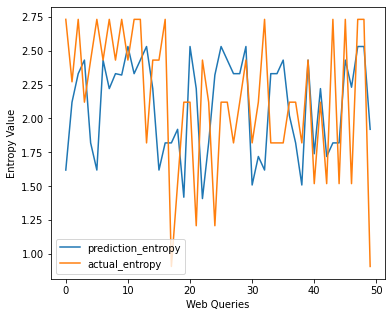

In [33]:
plot_df.plot(figsize=(6,5))
plt.ylabel('Entropy Value')
plt.xlabel('Web Queries')
plt.show()

In [35]:
plot_df['difference'] = plot_df['prediction_entropy'] - plot_df['actual_entropy']
plot_df['imporved percentage'] = (plot_df.prediction_entropy - plot_df.actual_entropy)/plot_df.prediction_entropy * 100
plot_df.describe()

,prediction_entropy,actual_entropy,difference,imporved percentage
count,50.000000,50.000000,50.000000,50.000000
mean,2.100200,2.150600,-0.050400,-5.233978
std,0.355519,0.508946,0.582272,31.444593
min,1.410000,0.910000,-1.110000,-72.340426
25%,1.820000,1.820000,-0.400000,-19.815454
50%,2.220000,2.120000,-0.100000,-4.621170
75%,2.430000,2.655000,0.377500,16.205534
max,2.530000,2.730000,1.110000,52.604167


##### The entropy reduced overall by 5.233% for 50 query
##### the result will be diifferent depend on number of queries 